# Reinforcement learning algorithms for Tic-Tac-Toe

The class State is used to represent a configuration of the game

In [1]:
import pickle
import random
import numpy as np
from math import log, sqrt

SIZE = 3

class State(object):
    def __init__(self):
        # a state is represented by a SIZE * SIZE array where:
        # 0 represents an empty position
        # 1 represents a cross (symbol for player 1),
        # 2 represents a circle (symbol for player 2)
        self.data = np.zeros((SIZE, SIZE))
        # Player who's turn it is to play from this state
        self.player = 1
        self.hash = 0
        # The outcome can be
        # 1 if Player 1 wins
        # 0 if Player 2 wins
        # 0.5 if it's a tie
        # -1 if the game is not over
        # 2 if the outcome has never been computed
        self.outcome = 2

    def compute_outcome(self):
        # checks whether the game is over from this state and who won
        if self.outcome != 2:
            return self.outcome
        else:
            # checks rows
            for i in range(0, SIZE):
                if all(x == 1 for x in self.data[i, :]):
                    self.outcome = 1
                    return 1
                if all(x == 2 for x in self.data[i, :]):
                    self.outcome = 0
                    return 0

            # checks columns
            for j in range(0, SIZE):
                if all(x == 1 for x in self.data[:, j]):
                    self.outcome = 1
                    return 1
                if all(x == 2 for x in self.data[:, j]):
                    self.outcome = 0
                    return 0

            # checks diagonals
            diag = [self.data[i,i] for i in range(0, SIZE)]
            if all(x == 1 for x in diag):
                self.outcome = 1
                return 1
            if all(x == 2 for x in diag):
                self.outcome = 0
                return 0

            anti_diag = [self.data[i,SIZE - 1 - i] for i in range(0, SIZE)]
            if all(x == 1 for x in anti_diag):
                self.outcome = 1
                return 1
            if all(x == 2 for x in anti_diag):
                self.outcome = 0
                return 0

            # check whether it's a tie
            data_all = [self.data[i,j] for i in range(0, SIZE) for j in range(0, SIZE)]
            if all(x != 0 for x in data_all):
                self.outcome = 0.5
                return 0.5

            # if we reached this point the game is still going on
            self.outcome = -1
            return -1

    def print_state(self):
        # prints the board
        for i in range(0, SIZE):
            print('-------------')
            out = '| '
            for j in range(0, SIZE):
                if self.data[i, j] == 1:
                    token = 'x'
                elif self.data[i, j] == 2:
                    token = 'o'
                else:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')

    def legal_plays(self):
        # returns the set of legal moves from that state
        legal = []
        for i in range(0, SIZE):
            for j in range(0, SIZE):
                if self.data[i, j] == 0:
                    legal.append((i,j))
        return legal

    def compute_hash(self):
        # hash function. It is actually not useful because hashes are computed recursively
        self.hash = 0
        for i in self.data.reshape(SIZE * SIZE):
            self.hash = self.hash * 3 + i
        return self.hash

    def next_state(self, i, j):
        # returns a new state corresponding to the state reached after playing in (i,j)
        new_state = State()
        new_state.data = np.copy(self.data)
        new_state.data[i, j] = self.player
        new_state.hash = self.hash + 3 ** (SIZE * i + j) * self.player
        new_state.player = 3 - self.player
        return new_state
     
    def update_state(self, i, j):
        # updates the current state by playing in (i,j)
        self.data[i, j] = self.player
        self.hash = self.hash + 3 ** (SIZE * i + j) * self.player
        self.player = 3 - self.player
        self.outcome = 2

The Class Player describes a generic player. Every algorithm will inherit from this class.
The two aspects common to all players are:
* a value function mapping states to numbers (using a dictionary)
* a play function choosing the next move by maximising or minimising the value

In [2]:
class Player():
    def __init__(self):
        self.values = dict()
        self.name = "Generic"

    def play(self, state, verbose = False):
        # takes the state and returns the move to be applied
        if not state.hash in self.values:
            if verbose:
                print("The player had never seen that state!")
            return random.choice(state.legal_plays())
        else:
            if verbose:
                print("%s player's turn as player %d.\nCurrent value: %0.5f"  % (self.name, state.player, self.values[state.hash]))
                print("Available moves and their values:")
                if state.player == 1:
                    print([((i,j),self.values[(state.next_state(i,j)).hash]) for (i,j) in state.legal_plays()
                           if (state.next_state(i,j)).hash in self.values])
                else:
                    print([((i,j),self.values[(state.next_state(i,j)).hash]) for (i,j) in state.legal_plays()
                           if (state.next_state(i,j)).hash in self.values])

            # for more fun, we randomise over the most interesting moves
            if state.player == 1:
                evaluated_moves = [(self.values[(state.next_state(i, j)).hash], (i,j)) for (i, j) in state.legal_plays() if (state.next_state(i, j)).hash in self.values]
                max_val, _ = max(evaluated_moves)
                interesting_moves = [(i, j) for (v,(i, j)) in evaluated_moves if v == max_val]
            else:
                evaluated_moves = [(self.values[(state.next_state(i, j)).hash], (i,j)) for (i, j) in state.legal_plays() if (state.next_state(i, j)).hash in self.values]
                min_val, _ = min(evaluated_moves)
                interesting_moves = [(i, j) for (v,(i, j)) in evaluated_moves if v == min_val]
            return random.choice(interesting_moves)


The random player is the easiest to implement

In [3]:
class Player_random(Player):
    def __init__(self):
        Player.__init__(self)
        self.name = "Random"

The optimal player has a function solve which computes the exact values through a min-max algorithm

In [4]:
class Player_optimal(Player):
    def __init__(self):
        Player.__init__(self)
        self.name = "Optimal"

    def solve(self, state = State()):
        # computes the (exact) values recursively
        if state.compute_outcome() != -1:
            self.values[state.hash] = state.outcome
        else:
            if state.player == 1:
                current_val = 0
                for (i,j) in state.legal_plays():
                    next = state.next_state(i,j)
                    if not (next.hash in self.values):
                        self.solve(next)
                    current_val = max(current_val,self.values[next.hash])
                self.values[state.hash] = current_val
            else:
                current_val = 1
                for (i,j) in state.legal_plays():
                    next = state.next_state(i,j)
                    if not (next.hash in self.values):
                        self.solve(next)
                    current_val = min(current_val,self.values[next.hash])
                self.values[state.hash] = current_val

The Monte Carlo player has a function train which runs many simulations, using the epsilon-greedy strategy: it plays at random with probability epsilon, and maximises or minimises the current value otherwise.
The strategy is played against itself (self-play). 
We count the number of win, loss and ties for each state and use it for computing the value in the end.

In [5]:
class Player_MC(Player):
    def __init__(self, epsilon = 0.1):
        Player.__init__(self)
        self.name = "Monte Carlo"

        # for training purposes
        self.epsilon = epsilon

        # plays counts for each state how many plays included this state
        self.plays = dict()

        # values_normalised is values multiplied by plays, which is easier to maintain
        self.values_normalised = dict()

    def play_during_training(self, state):
        # takes the state and returns the move to be applied
        if random.random() < self.epsilon:
            return random.choice(state.legal_plays())
        else:
            possible_states = [((i, j), state.next_state(i, j)) for (i, j) in state.legal_plays()]
            if all(next.hash in self.plays for ((i, j), next) in possible_states):
                # if we have seen all of the legal moves at least once, we use the UCB bound.
                if state.player == 1:
                    _, (i, j) = max((self.values_normalised[next.hash] / self.plays[next.hash], (i, j)) for ((i, j), next) in possible_states)
                else:
                    _, (i, j) = min((self.values_normalised[next.hash] / self.plays[next.hash], (i, j)) for ((i, j), next) in possible_states)
            else:
                # otherwise choose randomly among unevaluated moves
                unevaluated_moves = [(i, j) for (i, j) in state.legal_plays() if not (state.next_state(i, j)).hash in self.plays]
                (i, j) = random.choice(unevaluated_moves)
            return i,j

    def store_new_state(self, state):
        if not(state.hash in self.plays):
            self.plays[state.hash] = 0
            self.values[state.hash] = 0
            self.values_normalised[state.hash] = 0

    def run_simulation(self):
        state = State()
        state.hash = 0
        self.store_new_state(state)
        self.plays[state.hash] += 1

        # we store the play in a sequence
        play = []

        while (state.compute_outcome() == -1):
            play.append(state.hash)
            i, j = self.play_during_training(state)
            state.update_state(i, j)
            self.store_new_state(state)
            self.plays[state.hash] += 1

        self.values_normalised[state.hash] += state.outcome
        for hash_val in play:
            self.values_normalised[hash_val] += state.outcome

    def train(self, number_simulations, verbose = False):
        # approximates the values through Monte Carlo simulation.
        if verbose:
            print("Start training of Player %s" % self.name)
        for t in range(1,number_simulations+1):
            self.run_simulation()
            if verbose and t % 100 == 0:
                print("After %d iterations the value of the initial state is %0.5f" % (t, (self.values_normalised[0] / self.plays[0])))

        # computes the values.
        for hash_val in self.plays:
            self.values[hash_val] = self.values_normalised[hash_val] / self.plays[hash_val]

The UCB (Upper Confidence Bound) player is very similar to Monte Carlo, except that instead of playing epsilon-greedy strategies, it uses the UCB formula which induces a tradeoff between exploration and exploitation.
From a state if all available moves have been explored the strategy chooses the move which maximises or minimises the sum of two terms, one being the current value and the other one indicating how precise is the current value estimate. 
The constant C controls the exploitation.

In [6]:
class Player_UCB(Player):
    def __init__(self, C = 1.4):
        Player.__init__(self)
        self.name = "UCB"

        # for training purposes
        self.C = C

        # plays counts for each state how many plays included this state
        self.plays = dict()

        # values_normalised is values multiplied by plays, which is easier to maintain
        self.values_normalised = dict()

    def play_during_training(self, state):
        # takes the state and returns the move to be applied
        possible_states = [((i, j), state.next_state(i, j)) for (i, j) in state.legal_plays()]
        if all(next.hash in self.plays for ((i, j), next) in possible_states):
            # if we have seen all of the legal moves at least once, we use the UCB bound
            if state.player == 1:
                _, (i, j) = max(
                    (self.values_normalised[next.hash] / self.plays[next.hash] +
                     self.C * sqrt(log(self.plays[state.hash]) / self.plays[next.hash]), (i, j))
                    for ((i, j), next) in possible_states)
            else:
                _, (i, j) = min(
                    (self.values_normalised[next.hash] / self.plays[next.hash] -
                     self.C * sqrt(log(self.plays[state.hash]) / self.plays[next.hash]), (i, j))
                    for ((i, j), next) in possible_states)
        else:
            # otherwise choose randomly among unevaluated moves
            unevaluated_moves = [(i, j) for (i, j) in state.legal_plays() if not (state.next_state(i, j)).hash in self.plays]
            (i, j) = random.choice(unevaluated_moves)
        return i,j

    def store_new_state(self, state):
        if not(state.hash in self.plays):
            self.plays[state.hash] = 0
            self.values[state.hash] = 0
            self.values_normalised[state.hash] = 0

    def run_simulation(self):
        state = State()
        self.store_new_state(state)
        self.plays[state.hash] += 1

        # we store the play in a sequence
        play = []

        while(state.compute_outcome() == -1):
            play.append(state.hash)
            i, j = self.play_during_training(state)
            state.update_state(i, j)
            self.store_new_state(state)
            self.plays[state.hash] += 1

        self.values_normalised[state.hash] += state.outcome
        for hash_val in play:
            self.values_normalised[hash_val] += state.outcome

    def train(self, number_simulations, verbose = False):
        # approximates the values through Monte Carlo simulation
        if verbose:
            print("Start training of Player %s" % self.name)
        for t in range(1,number_simulations+1):
            self.run_simulation()
            if verbose and t % 100 == 0:
                print("After %d iterations the value of the initial state is %0.5f" % (t, self.values_normalised[0] / self.plays[0]))

        # computes the values
        for hash_val in self.plays:
            self.values[hash_val] = self.values_normalised[hash_val] / self.plays[hash_val]

The TD (Temporal Difference) player uses epsilon-greedy strategies like the Monte Carlo player. The difference is in how the values are computed: rather than taking the average over all plays containing the given state, the values are updated locally based on the current value estimates of the next state.

In [7]:
class Player_TD(Player):
    def __init__(self, step_size = 0.2, epsilon = 0.1):
        Player.__init__(self)
        self.name = "TD"

        # for training purposes
        self.step_size = step_size
        self.epsilon = epsilon

    def play_during_training(self, state, t):
        # takes the state and returns the move to be applied
        if random.random() < self.epsilon / (t ** 0.5):
            return random.choice(state.legal_plays())
        else:
            possible_states = [((i, j), state.next_state(i, j)) for (i, j) in state.legal_plays()]
            if all(next.hash in self.values for ((i, j), next) in possible_states):
                # if we have seen all of the legal moves at least once, we use the value
                if state.player == 1:
                    _, (i, j) = max((self.values[next.hash], (i, j)) for ((i, j), next) in possible_states)
                else:
                    _, (i, j) = min((self.values[next.hash], (i, j)) for ((i, j), next) in possible_states)
            else:
                # otherwise choose randomly among unevaluated moves
                unevaluated_moves = [(i, j) for (i, j) in state.legal_plays() if
                                     not (state.next_state(i, j)).hash in self.values]
                (i, j) = random.choice(unevaluated_moves)
            return (i, j)

    def store_new_state(self, state):
        if not (state.hash in self.values):
            self.values[state.hash] = 0

    def run_simulation(self, t):
        state = State()
        self.store_new_state(state)

        play = []
        while (state.compute_outcome() == -1):
            (i, j) = self.play_during_training(state, t)
            play.append(state.hash)
            state.update_state(i, j)
            self.store_new_state(state)

        next_hash_val = state.hash
        self.values[next_hash_val] = state.outcome
        for (hash_val) in reversed(play):
            td_error = self.values[next_hash_val] - self.values[hash_val]
            self.values[hash_val] += self.step_size * td_error
            next_hash_val = hash_val


    def train(self, number_simulations, verbose=False):
        # approximates the values through Monte Carlo simulation
        if verbose:
            print("Start training of Player %s" % self.name)
        for t in range(1,number_simulations+1):
            self.run_simulation(t)
            if verbose and t % 500 == 0:
                print("After %d iterations the value of the initial state is %0.5f" % (t, self.values[0]))

# Tests

The class Competition is used to play strategies against each other

In [8]:
class Competition(object):
    def save_values(self, name, player):
        # saves the value function
        with open('strategy_%s.bin' % name, 'wb') as f:
            pickle.dump(player.values, f)

    def load_values(self, name, player):
        # loads a value function
        with open('strategy_%s.bin' % name, 'rb') as f:
            player.values = pickle.load(f)

    def play(self, player1, player2, verbose=False):
        # takes two strategies (one for each player), play them against each other once and declare an outcome
        state = State()
        state.hash = 0

        if verbose:
            print("Match between Player %s (as Player 1) and Player %s (as Player 2)" % (player1.name, player2.name)) 

        while(state.compute_outcome() == -1):
            if verbose:
                state.print_state()
            if state.player == 1:
                i, j = player1.play(state, verbose)
                state.update_state(i, j)
                if verbose:
                    print("Player %d chooses (%d,%d)" % (1, i, j))
            else:
                i, j = player2.play(state, verbose)
                state.update_state(i, j)
                if verbose:
                    print("Player %d chooses (%d,%d)" % (2, i, j))

        if verbose:
            print("Final state")
            state.print_state()
            if state.outcome == 1:
                print("Player 1 won")
            elif state.outcome == 0:
                print("Player 2 won")
            else:
                print("It's a tie!")
        return state.outcome

    def compete(self, player1, player2, games = 500):
        # takes two strategies (one for each player) and play them against each other a number of times
        player1_win = 0.0
        player2_win = 0.0
        for _ in range(games):
            outcome = self.play(player1,player2)
            if outcome == 1:
                player1_win += 1
            if outcome == 0:
                player2_win += 1
        print("Competition results: %d plays, player 1 wins %.02f, player 2 wins %.02f" % (games, player1_win / games, player2_win / games))

    def ensures_tie(self, player1, player2, games = 50):
        # checks whether player1 ensures ties against player2 over a number of games
        i = 0
        while i < games:
            if self.play(player1,player2) == 0:
                return i
            i += 1
        return games

We instantiate all the players (with default parameters).
For convenience the value functions are loaded to avoid training each of them again.
Uncomment for training them again and saving the value functions.

In [9]:
competition = Competition()

player_rand = Player_random()
player_optimal = Player_optimal()
player_mc = Player_MC()
player_ucb = Player_UCB()
player_td = Player_TD()

#player_optimal.solve()
#competition.save_values("optimal", player_optimal)
competition.load_values("optimal", player_optimal)

# since the min-max algorithm explores all possible states, 
# we can use the value function to know how many states are reachable
#print("Number of reachable states: %d" % len(player_optimal.values))

player_mc.train(20000, False)
competition.save_values("MC_20000", player_mc)
#competition.load_values("MC_20000", player_mc)

player_ucb.train(10000, False)
competition.save_values("UCB_10000", player_ucb)
#competition.load_values("UCB_10000", player_ucb)

player_td.train(2000, True)
competition.save_values("TD_2000", player_td)
#competition.load_values("TD_2000", player_td)

Start training of Player TD
After 500 iterations the value of the initial state is 0.06018
After 1000 iterations the value of the initial state is 0.49075
After 1500 iterations the value of the initial state is 0.49999
After 2000 iterations the value of the initial state is 0.47126


## Playing the different algorithms against the optimal player

In [10]:
competition.play(player_mc,player_optimal,False)
competition.compete(player_mc,player_optimal)

competition.play(player_ucb,player_optimal,False)
competition.compete(player_ucb,player_optimal)

competition.play(player_td,player_optimal,True)
competition.compete(player_td,player_optimal)

Competition results: 500 plays, player 1 wins 0.00, player 2 wins 0.00
Competition results: 500 plays, player 1 wins 0.00, player 2 wins 0.00
Match between Player TD (as Player 1) and Player Optimal (as Player 2)
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
TD player's turn as player 1.
Current value: 0.47126
Available moves and their values:
[((0, 0), 3.5840000000000016e-06), ((0, 1), 2.5600000000000013e-06), ((0, 2), 0.0016000000000000005), ((1, 0), 0.0), ((1, 1), 0.0007526935429120002), ((1, 2), 5.376000000000002e-05), ((2, 0), 6.400000000000002e-05), ((2, 1), 3.5840000000000016e-06), ((2, 2), 0.4803169643188741)]
Player 1 chooses (2,2)
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   |   | x | 
-------------
Optimal player's turn as player 2.
Current value: 0.50000
Available moves and their values:
[((0, 0), 1), ((0, 1), 1), ((0, 2), 1), ((1, 0), 1), ((1, 1), 0.5), ((1, 2), 1), ((2, 0), 1), ((2, 1), 

## How many iterations to ensure a tie against the optimal player?

In [11]:
def how_many_iterations(player,steps = 100, games = 500, verbose = False):
    iteration = 0
    while(True):
        player.train(steps)
        iteration += steps
        result = competition.ensures_tie(player,player_optimal,games)
        if result == games:
            return(iteration)
        elif(verbose):
            print("After %d iterations, Player %s lost the match number %d" % (iteration, player.name, result))

# we define some new players to forget about the previously trained ones
player_mc = Player_MC()
player_ucb = Player_UCB()
player_td = Player_TD()

print(how_many_iterations(player_mc, steps = 100, games = 50, verbose = False))
print(how_many_iterations(player_ucb, steps = 100, games = 50, verbose = False))
print(how_many_iterations(player_td, steps = 100, games = 50, verbose = True))

1200
3200
After 100 iterations, Player TD lost the match number 0
After 200 iterations, Player TD lost the match number 0
300


## Parameter tuning

We explore the influence of the different parameters for each of the players.
Running the statistics takes a long time since we train a lot of players!

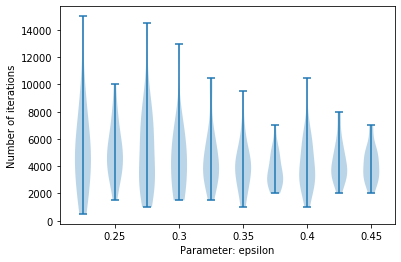

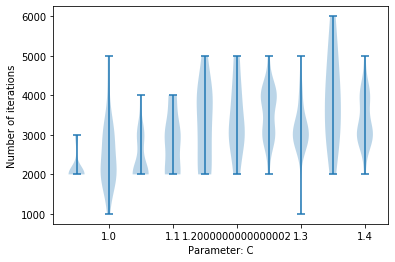

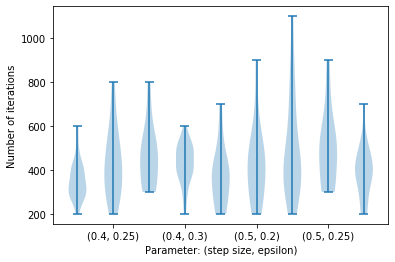

In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def run_statistics_mc(parameter_list, number_tests, steps, games):
    out = [[] for i in range(len(parameter_list))]
    for index,parameter in enumerate(parameter_list):
        for i in range(number_tests):
            player_mc = Player_MC(epsilon=parameter)
            out[index].append(how_many_iterations(player_mc,steps,games,verbose=False))
    with open('statistics_MC.bin', 'wb') as f:
        pickle.dump(out, f)
    return(out)

parameter_list_mc = [(i+4) / 20 for i in range(10)]
#run_statistics_mc(parameter_list_mc, number_tests = 20, steps = 500, games = 50)

def run_statistics_ucb(parameter_list, number_tests, steps, games):
    out = [[] for i in range(len(parameter_list))]
    for index,parameter in enumerate(parameter_list):
        for i in range(number_tests):
            player_ucb = Player_UCB(C=parameter)
            out[index].append(how_many_iterations(player_ucb,steps,games,verbose=False))
    with open('statistics_UCB.bin', 'wb') as f:
        pickle.dump(out, f)
    return(out)

parameter_list_ucb = [.8 + (i+1) / 10 for i in range(10)]
#run_statistics_ucb(parameter_list_ucb, number_tests = 20, steps = 1000, games = 50)

def run_statistics_td(parameter_list, number_tests, steps, games):
    out = [[] for i in range(len(parameter_list))]
    for index,parameter in enumerate(parameter_list):
        for i in range(number_tests):
            player_td = Player_TD(step_size=parameter[0],epsilon=parameter[1])
            out[index].append(how_many_iterations(player_td,steps,games,verbose=False))
    with open('statistics_TD.bin', 'wb') as f:
        pickle.dump(out, f)
    return(out)

parameter_list_td = [(0.4 + i/10, (j+4) / 20) for i in range(3) for j in range(3)]
#run_statistics_td(parameter_list = parameter_list_td, number_tests = 20, steps = 100, games = 50)

def print_statistics(name_file, parameter_list, name_parameters):
    with open('%s.bin' % name_file, 'rb') as f:
        out = pickle.load(f)
    fig, ax = plt.subplots()
    ax.violinplot(out)
    ax.set_xticklabels(parameter_list)
    ax.set_xlabel("Parameter: %s" %name_parameters)
    ax.set_ylabel("Number of iterations")
    plt.savefig('%s.png' % name_file)
    plt.show()
    plt.close()

print_statistics('statistics_MC', parameter_list_mc, 'epsilon')
print_statistics('statistics_UCB', parameter_list_ucb, 'C')
print_statistics('statistics_TD', parameter_list_td, '(step size, epsilon)')